# exp047_train
[Notion](https://www.notion.so/exp031-18d8225cac2841c0801c8c0573796334?pvs=4)  
exp031モデルの最適パラメータの探索に入る.
Copy from: exp031_train <- exp024_train <- exp014_train <- exp009_train <- exp008_train <- exp007_train  


In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from typing import Tuple

import albumentations as A
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.cuda.amp as amp
from sklearn.model_selection import GroupKFold
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')

from src.classification.dataset import TrainDatasetSolidOrgans as TrainDataset
from src.classification.dataset import save_df
from src.image_processing import windowing
from src.logger import get_logger
from src.loss import BCEDiceLoss, DiceCoef
from src.classification.model import lock_model_encoder_weight
from src.classification.trainer import fit_model
from src.samplar import MultilabelBalancedRandomSampler
from models.efficientnet_pytorch_3d import EfficientNet3D

# Config

In [2]:
class CFG:
    exp_name = 'exp_047'
    # model config
    # timm backbone
    backbone = 'efficientnet-b4'
    n_ch = 1
    expand_ch_dim = True
    # n_class: healthy, low, high
    n_class = 3
    # hyper params
    apply_3d_aug = False
    wl = 0
    ww = 1000
    init_lr = 1e-3
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (128, 128, 160)
    batch_size = 64
    amp = True
    eps = 1e-6
    n_epoch = 30
    pretrain = True
    freeze_epochs = 0
    noaug_epochs = 2
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset002"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 4
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_weight=torch.tensor([1.0, 1.0, 1.0]).to(device)

In [3]:
# create output dir
os.makedirs(os.path.join(CFG.model_save_dir, CFG.exp_name), exist_ok=True)

# get label correspondences
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# seed setting
def seed_everything(seed=CFG.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

# logger setting
logger = get_logger(CFG)

# load dataframe
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_series_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

# Dataset

In [4]:
def get_training_dataframe():
    """データセットのDataFrameを作成する.
    データセットによって内容を書き換える必要あり.
    """
    # df_seg_info_imageをベースに、学習用データフレームを構築.
    # df_seg_info_imageは、exp002で作成されるcsvファイル.
    path_dict = defaultdict(list)
    for i in range(len(df_train_series_meta)):
        sr = df_train_series_meta.iloc[i]
        pid, sid = int(sr["patient_id"]), int(sr["series_id"])

        sr_label = df_train[df_train["patient_id"] == pid].iloc[0]
        for organ in ["liver", "spleen", "kidney"]:
            image_path = os.path.join(CFG.image_dir, str(pid), str(sid), f"{organ}.npy")
            path_dict["patient_id"].append(pid)
            path_dict["series_id"].append(sid)
            path_dict["organ"].append(organ)
            path_dict["image_path"].append(image_path)
            path_dict["healthy"].append(sr_label[organ+"_healthy"])
            path_dict["low"].append(sr_label[organ+"_low"])
            path_dict["high"].append(sr_label[organ+"_high"])


    # 画像データのDataFrameを作成
    df = pd.DataFrame(path_dict)

    # 画像データのDataFrameに、foldの情報を追加.
    # 正しいデータ分割のため、患者IDごとに分ける.
    df['fold'] = -1
    gkf = GroupKFold(n_splits=CFG.n_fold)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, groups=df['patient_id'])):
        df.loc[val_idx, 'fold'] = fold
    
    return df

In [5]:
df = get_training_dataframe()
save_df(df, CFG)
df.head()

,patient_id,series_id,organ,image_path,healthy,low,high,fold
0,10004,21057,liver,data/dataset002/10004/21057/liver.npy,1,0,0,1
1,10004,21057,spleen,data/dataset002/10004/21057/spleen.npy,0,0,1,1
2,10004,21057,kidney,data/dataset002/10004/21057/kidney.npy,0,1,0,1
3,10004,51033,liver,data/dataset002/10004/51033/liver.npy,1,0,0,1
4,10004,51033,spleen,data/dataset002/10004/51033/spleen.npy,0,0,1,1


In [6]:
def apply_preprocess(image: np.ndarray)-> np.ndarray:
    """データ前処理. カスタマイズして使用.
    Args:
        image (numpy.ndarray): HU値のCT画像.
    Returns:
        image (numpy.ndarray): windowing及び0~1に正規化.
    """
    # 0~1に正規化
    image = windowing(image, wl=CFG.wl, ww=CFG.ww, mode="float32")
    return image

def get_aug():
    """データ拡張. カスタマイズして使用.
    Note:
        画像のResizeはDataset側で行うので、この関数に入れる必要はない.
    """
    return A.Compose(
        [
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5
            ),
            A.RandomBrightnessContrast(p=0.5),
            A.CoarseDropout(
                max_holes=8,
                max_height=CFG.image_size[0] // 20,
                max_width=CFG.image_size[1] // 20,
                min_holes=5,
                fill_value=0,
                mask_fill_value=0,
                p=0.5,
            ),
        ],
        p=1.0,
    )

In [7]:
ds = TrainDataset(CFG, df, preprocess=apply_preprocess, tfms=get_aug())

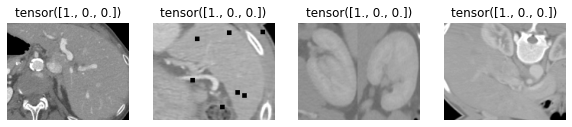

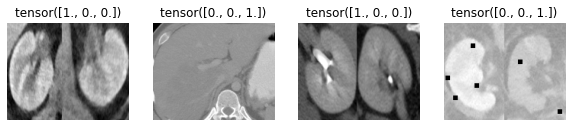

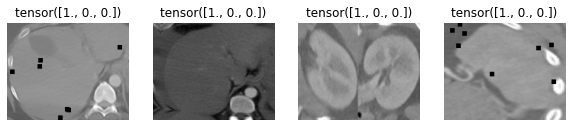

In [8]:
for i in range(3):
    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    for j in range(4):
        img, label = ds[random.randint(0, len(ds)-1)]
        ax[j].imshow(img.numpy()[0, img.shape[1]//2], cmap='gray')
        ax[j].set_title(label)

    for j in range(4):
        ax[j].grid(False)
        ax[j].axis(False)

In [9]:
result_dict = {}

for fold in range(CFG.train_folds):
    logger.info(f"Fitting on Fold {fold+1}")
    # Dataset
    if CFG.include_evaluation: # evaluation用のデータを最後のfoldに含める場合
        df_train = df[(df["fold"] != fold) & (df["fold"] != CFG.n_fold-1)].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    else:
        df_train = df[df["fold"] != fold].reset_index(drop=True)
        df_valid = df[df["fold"] == fold].reset_index(drop=True)
    train_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=get_aug()
    )
    valid_data = TrainDataset(CFG, df_valid, preprocess=apply_preprocess, tfms=None)

    # Sampler
    # 各クラスを均等に学習することで、効率的に学習する.
    """train_sampler = MultilabelBalancedRandomSampler(
        CFG,
        df_train[['liver', 'spleen', 'kidney', 'bowel', 'any_inv']].to_numpy(),
        class_choice="random",
        num_iteration=CFG.iteration_per_epoch
    )
    valid_sampler = MultilabelBalancedRandomSampler(
        CFG,
        df_valid[['liver', 'spleen', 'kidney', 'bowel', 'any_inv']].to_numpy(),
        class_choice="random",
        num_iteration=CFG.iteration_per_epoch//5
    )"""

    # Data Loader
    train_iterator = DataLoader(
        train_data,
        shuffle=True, # sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )
    valid_iterator = DataLoader(
        valid_data,
        shuffle=True, # sampler=valid_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    # noaug_iterator
    train_noaug_data = TrainDataset(
        CFG, df_train, preprocess=apply_preprocess, tfms=None
    )
    train_noaug_iterator = DataLoader(
        train_noaug_data,
        shuffle=True, # sampler=train_sampler,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        pin_memory=True,
    )

    if CFG.amp:
        model = EfficientNet3D.from_name(
            CFG.backbone, 
            override_params={'num_classes': CFG.n_class}, 
            in_channels=CFG.n_ch
        ).to(CFG.device)
        scaler = amp.GradScaler()
    else:
        model = EfficientNet3D.from_name(
            CFG.backbone, 
            override_params={'num_classes': CFG.n_class}, 
            in_channels=CFG.n_ch
        ).to(CFG.device)
        scaler = None
    if CFG.num_gpus > 1:
        model = nn.DataParallel(model)

    model_name = f"{CFG.exp_name}_f{fold}"

    if CFG.freeze_epochs:
        logger.info("+-+-+-+-+-+-+-+-+")
        logger.info("pretrain mode")
        logger.info("+-+-+-+-+-+-+-+-+")

        loss_criterion = nn.BCEWithLogitsLoss(CFG.class_weight)
        opt = AdamW(model.parameters(), lr=CFG.init_lr, eps=CFG.eps)
        scheduler = None

        model = lock_model_encoder_weight(model, mode="lock")

        _ = fit_model(
            CFG,
            model,
            model_name,
            train_iterator,
            train_noaug_iterator,
            valid_iterator,
            opt,
            loss_criterion,
            True,
            scaler,
            logger,
            scheduler,
            organ_index_dict_inv
        )

    logger.info("@*@*@*@*@*@*@*@*@")
    logger.info("fulltrain mode")
    logger.info("@*@*@*@*@*@*@*@*@")

    loss_criterion = nn.BCEWithLogitsLoss(CFG.class_weight)
    opt = AdamW(model.parameters(), lr=CFG.init_lr, weight_decay=CFG.weight_decay, eps=CFG.eps)
    scheduler = CosineAnnealingLR(opt, CFG.n_epoch, eta_min=CFG.min_lr)

    model = lock_model_encoder_weight(model, mode="unlock")
    
    tr_loss, val_loss, val_metrics = fit_model(
        CFG,
        model,
        model_name,
        train_iterator,
        train_noaug_iterator,
        valid_iterator,
        opt,
        loss_criterion,
        False,
        scaler,
        logger,
        scheduler,
        organ_index_dict_inv
    )

    result = {
        "tr_loss": tr_loss, 
        "val_loss": val_loss, 
        "val_metrics": val_metrics,
    }
    result_dict[model_name] = result

2023-10-07 10:24:01,380 INFO: Fitting on Fold 1
2023-10-07 10:24:01,478 INFO: @*@*@*@*@*@*@*@*@
2023-10-07 10:24:01,479 INFO: fulltrain mode
2023-10-07 10:24:01,479 INFO: @*@*@*@*@*@*@*@*@
Validation loss: 0.41460: 100%|██████████| 37/37 [01:22<00:00,  2.23s/it]
2023-10-07 10:33:27,820 INFO: Epoch: 01 | Epoch Time: 9m 26s
2023-10-07 10:33:27,821 INFO: lr:0.0010000
2023-10-07 10:33:27,821 INFO: Train Loss: 0.276
2023-10-07 10:33:27,821 INFO: Val. Loss: 0.401 | Val. Logloss Score : 0.685,
Validation loss: 0.22210: 100%|██████████| 37/37 [01:22<00:00,  2.22s/it]
2023-10-07 10:42:50,733 INFO: Epoch: 02 | Epoch Time: 9m 23s
2023-10-07 10:42:50,734 INFO: lr:0.0009973
2023-10-07 10:42:50,734 INFO: Train Loss: 0.238
2023-10-07 10:42:50,734 INFO: Val. Loss: 0.240 | Val. Logloss Score : 0.397,
Validation loss: 0.28590: 100%|██████████| 37/37 [01:22<00:00,  2.22s/it]
2023-10-07 10:52:13,869 INFO: Epoch: 03 | Epoch Time: 9m 23s
2023-10-07 10:52:13,870 INFO: lr:0.0009891
2023-10-07 10:52:13,871 INF

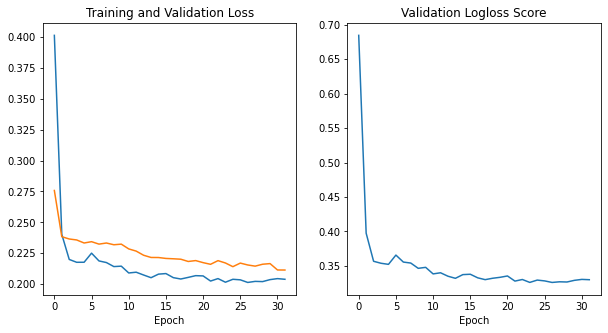

In [10]:
for fold in range(CFG.train_folds):
    model_name = f"{CFG.exp_name}_f{fold}"
    val_loss = result_dict[model_name]["val_loss"]
    val_dice = result_dict[model_name]["val_metrics"]
    tr_loss = result_dict[model_name]["tr_loss"]

    fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    ax[0].plot(val_loss)
    ax[0].plot(tr_loss)
    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(val_dice)
    ax[1].set_title('Validation Logloss Score')
    ax[1].set_xlabel('Epoch')